In [ ]:
arrow::read_parquet(here("data", "atpTrans.parquet")) -> atp
atp %>% glimpse()

Rows: 682,069
Columns: 27
$ winner.name            <chr> "Patrick Rafter", "Dennis Van Scheppingen", "Ja…
$ winner.id              <chr> "r255", "s559", "s381", "d214", "r255", "s559",…
$ winner.rank            <int> 6, 126, 26, 85, 6, 126, 26, 11, 85, 6, 12, 55, …
$ winner.bornAt          <chr> "Australia", "Netherlands", "Netherlands", "Cze…
$ winner.domHand         <chr> "Right-Handed", "Right-Handed", "Left-Handed", …
$ winner.backHand        <chr> "One-Handed Backhand", "Unknown Backhand", "Unk…
$ winner.height          <int> 185, 185, 183, 188, 185, 185, 183, 185, 188, 18…
$ looser.name            <chr> "Martin Damm", "Richard Krajicek", "Steve Campb…
$ looser.id              <chr> "d214", "k214", "c355", "k237", "s572", "w254",…
$ looser.rank            <int> 85, 12, 95, 11, 55, 189, 58, 60, 100, 94, 42, 3…
$ looser.bornAt          <chr> "Czech Republic", "Netherlands", "USA", "Czech …
$ looser.domHand         <chr> "Right-Handed", "Right-Handed", "Right-Handed",…
$ looser.backH

In [ ]:
atp %>% filter(tournament.location == "Australia") -> atpA

In [ ]:
# parquet doesn't seem to save factor
atpA %>% mutate(
        winner.backHand = winner.backHand             %>% as.factor,
        winner.domHand  = winner.domHand              %>% as.factor,
        looser.backHand = looser.backHand             %>% as.factor,
        looser.domHand  = looser.domHand              %>% as.factor,
        match.tournamentRound = match.tournamentRound %>% as.factor,
        tournament.ground = tournament.ground         %>% as.factor,
        tournament.location = tournament.location     %>% as.factor
    ) -> atpAF

In [ ]:
if (FALSE) {
    atpAF %>% SmartEDA::ExpReport(op_file = "temp.html")
}

In [ ]:
(atpAF %>% nrow() -> nmatches.inicial)

[1] 21388

In [ ]:
# things to fix:
# prize ✔
# maybe dont include those that are both heights missing✔
# remove rets walkovers and defs✔
# decide on how to remove best of 5 tournaments✔
# turn nas into a factor too in backhand and domHand (backhand already has an unkown)
# fazer eda do rank para perceber como tratalos
# tratar heights✔

In [ ]:
# prize
atpAF %>% 
    select(tournament.prize) %>%
    filter(str_detect(tournament.prize, fixed("$"), negate=T))

tournament.prize
<chr>


In [ ]:
# no prizes without dollar
atpAF %>%
    mutate(tp = str_remove_all(tournament.prize, r"{[,\$]}")) %>%
    filter(str_detect(tp, r"{[^0-9]}")) %>% 
    select(tp)

tp
<chr>
A9609870
A9609870
A9609870
A9609870
A9609870
A9609870
A9609870
A9609870
A9609870


In [ ]:
# australian dollar
atpAF %>%
    mutate(tp = str_remove_all(tournament.prize, r"{[,\$A]}")) %>%
    filter(str_detect(tp, r"{[^0-9]}")) %>% 
    select(tp)

tp
<chr>


In [ ]:
doll_to_aus <- \(x) x*1.48
atpAF %>%
    rename(tp = tournament.prize) %>% 
    mutate(tournament.prize = case_when(
        tp %>% is.na()                 ~ NA,
        tp %>% str_detect(fixed("A$")) ~ tp %>% str_remove_all(r"{[\A$,]}") %>% as.double(),
        tp %>% str_detect(fixed("$"))  ~ tp %>% str_remove_all(r"{[\$,]}")  %>% as.double() %>% doll_to_aus(),
        TRUE ~ 9e+9
     )) %>% select(-tp) -> atpAFP
atpAFP %>% filter(tournament.prize == 9e+9) %>% nrow()

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `tournament.prize = case_when(...)`.
Caused by warning in `doll_to_aus()`:
! NAs introduced by coercion"


[1] 0

In [ ]:
library(skimr)
# atpAFP %>% skim(winner.height, looser.height) # yields error because of jup

In [ ]:
atpAFP %>% mutate(
    winner.height = ifelse(winner.height == 0, NA, winner.height), 
    looser.height = ifelse(looser.height == 0, NA, looser.height), 
) -> atpAFPH.wNA
# atpAFPH.wNA %>% skim(winner.height, looser.height)
# interpolate heights?
# maybe if we don't get enough observations

In [ ]:
atpAFPH <- atpAFPH.wNA %>% filter(!is.na(winner.height) & !is.na(looser.height))
# atpAFPH %>% skim(winner.height, looser.height)

In [ ]:
atpAFPH %>% filter(winner.height < 160) %>% distinct(winner.id)

winner.id
<chr>
s406
h431


In [ ]:
atpAFPH %>% filter(looser.height < 160) %>% distinct(looser.id)

looser.id
<chr>
s406
h431


TODO texto mas

* h431 -> 180 cm
* s406 -> 188 cm

In [ ]:
atpAFPHF <- atpAFPH %>% mutate(winner.height = case_when(
    winner.id == "h431" ~ 180,
    winner.id == "s406" ~ 188,
    TRUE ~ winner.height
), looser.height = case_when(
    looser.id == "h431" ~ 180,
    looser.id == "s406" ~ 188,
    TRUE ~ looser.height
))
# atpAFPHF %>% skim(winner.height, looser.height)

In [ ]:
atpAFPHFR <- atpAFPHF %>% 
    filter(!match.wasRet, !match.wasWalkover, !match.wasDef) %>%
    select(-match.wasRet, -match.wasWalkover, -match.wasDef)
# atpAFPHFR %>% select(starts_with("match")) %>% skim()

In [ ]:
# tournaments best of 5
atpAFPHFR -> atp.wbo5
atp.wbo5 %>% 
    group_by(tournament.name) %>% 
    filter(!any(match.setsCount > 3)) %>%
    ungroup() -> atp.wo45

In [ ]:
atp.wo45 %>% 
    group_by(tournament.name) %>% 
    filter(all(match.setsCount == 3)) %>% 
    summarise()

tournament.name
<chr>
AUS v. MAR WG PO
AUS v. SWE WG 1st RD
AUS vs. SVK WG Play-Off
Adelaide-2
ROM V AUS QF


TODO ver quais destes sao melhor de 3 e melhores de 5, dps tirar esses

In [ ]:
toRem = c("AUS v. MAR WG PO","AUS v. SWE WG 1st RD","AUS vs. SVK WG Play-Off","ROM V AUS QF")
atp.wo45 %>% filter(!(tournament.name %in% toRem)) -> atp.wobo5

In [ ]:
# Pode ainda assim haver jogos bo5 e bo3 nao filtrados, portanto vamos adaptar outra estrategia
atpRaw <- arrow::read_parquet(here("data", "atpRaw.parquet"))
atpRaw

,match.sets,match.tournamentRound,match.WL,opponent.name,opponent.rank,player.bornAt,player.hand,player.height,player.link,player.name,tournament.date,tournament.ground,tournament.location,tournament.name,tournament.prize
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,64 62,Semi-Finals,W,Marin Cilic,30,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.22 - 2021.12.05,Hard,"Madrid, Spain",Davis Cup Finals,
2,63 76,Round of 16,W,Karen Khachanov,26,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2022.02.21 - 2022.02.26,Hard,"Dubai, U.A.E.",Dubai,"$2,794,840"
3,62 61,Round Robin,W,Cameron Norrie,12,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.15 - 2021.11.21,Hard,"Turin, Italy",Nitto ATP Finals,"$7,250,000"
4,63 62,Round Robin,W,Andrey Rublev,5,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.15 - 2021.11.21,Hard,"Turin, Italy",Nitto ATP Finals,"$7,250,000"
5,46 63 63,Finals,W,Daniil Medvedev,2,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.01 - 2021.11.07,Hard,"Paris, France",ATP Masters 1000 Paris,"�5,207,405"
6,36 60 76,Semi-Finals,W,Hubert Hurkacz,10,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.01 - 2021.11.07,Hard,"Paris, France",ATP Masters 1000 Paris,"�5,207,405"
7,"76, 62",Round Robin,W,Casper Ruud,8,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.15 - 2021.11.21,Hard,"Turin, Italy",Nitto ATP Finals,"$7,250,000"
8,63 62,Round Robin,W,Dennis Novak,118,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.11.22 - 2021.12.05,Hard,"Madrid, Spain",Davis Cup Finals,
9,46 67,Quarter-Finals,L,Jiri Vesely,123,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2022.02.21 - 2022.02.26,Hard,"Dubai, U.A.E.",Dubai,"$2,794,840"


In [ ]:
# (promenores no transformacao)
atpScores<- atpRaw %>% mutate(
    match.sets = ifelse(str_detect(match.sets, "null") | str_trim(match.sets) == "", NA, match.sets),
) %>% filter(!(match.sets %>% str_detect(r"{(?i)\(RET\)|\(W/O\)|\(DEF\)|\(UNP\)}"))) %>%
    mutate(match.sets = str_remove_all(match.sets, fixed(",")) %>% str_squish()) %>%
    mutate(match.setsCount = str_count(match.sets, " ") + 1) %>%
    filter(match.setsCount == 3) %>% #all should be in format ## ## ##
    separate_longer_delim(match.sets, delim = " ") %>%
    distinct(match.sets)
atpScores

match.sets
<chr>
46
63
36
60
76
67
64
62
61


In [ ]:
atpRaw %>% filter(match.sets %>% str_detect(fixed("17-1564")))

match.sets,match.tournamentRound,match.WL,opponent.name,opponent.rank,player.bornAt,player.hand,player.height,player.link,player.name,tournament.date,tournament.ground,tournament.location,tournament.name,tournament.prize
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
36 63 17-1564,Round Robin,W,Francisco Gonzalez,86,"Sedan, France","Right-Handed, Unknown Backhand",193,https://www.atptour.com/en/players/yannick-noah/n022/player-activity?year=all&matchType=Singles,Yannick Noah,1985.03.04 - 1985.03.17,Hard,Paraguay,FRA V PAR 1RD,


Erros no numero de sets quando há "-" 

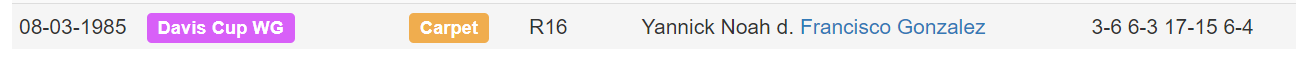

ptt

In [ ]:
atpScores %>% filter(!scores_9 %>% is.na)

tournament.name,match.sets,scores_1,scores_2,scores_3,scores_4,scores_5,scores_6,scores_7,scores_8,scores_9,scores_10,scores_11,scores_12
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AUT vs. ISR - EUROPE ZONE B SF,36 10 862,3,6,,1,0,,8,6,2,NA,NA,NA
Adelaide,64 8 1036,6,4,,8,,1,0,3,6,NA,NA,NA
South Orange,46 12 1057,4,6,,1,2,,1,0,5,7,NA,NA
BRA V ESP WGPO,10 1263 64,1,0,,1,2,6,3,,6,4,NA,NA
MEX V SUI WGPO,8 1026 46,8,,1,0,2,6,,4,6,NA,NA,NA
Wimbledon,36 15 1716,3,6,,1,5,,1,7,1,6,NA,NA
French Championships,12 1075 64,1,2,,1,0,7,5,,6,4,NA,NA
NZL V SWE 1RD,12 1062 97,1,2,,1,0,6,2,,9,7,NA,NA
SWE V AUS F,11 1311 1346,1,1,,1,3,1,1,,1,3,4,6


In [ ]:
atpRaw %>% filter(tournament.name == "Wimbledon")

match.sets,match.tournamentRound,match.WL,opponent.name,opponent.rank,player.bornAt,player.hand,player.height,player.link,player.name,tournament.date,tournament.ground,tournament.location,tournament.name,tournament.prize
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"76, 75 75",Semi-Finals,W,Denis Shapovalov,12,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
"67, 64 64 63",Finals,W,Matteo Berrettini,9,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
63 64 64,Quarter-Finals,W,Marton Fucsovics,48,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
62 64 62,Round of 16,W,Cristian Garin,20,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
64 63 76,Round of 32,W,Denis Kudla,114,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
63 63 63,Round of 64,W,Kevin Anderson,102,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
46 61 62 62,Round of 128,W,Jack Draper,253,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2021.06.28 - 2021.07.11,Grass,"London, Great Britain",Wimbledon,"�17,066,000"
"76, 16 76, 46 13-12",Finals,W,Roger Federer,3,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2019.07.01 - 2019.07.14,Grass,"London, Great Britain",Wimbledon,"�17,769,000"
62 46 63 62,Semi-Finals,W,Roberto Bautista Agut,22,"Belgrade, Serbia","Right-Handed, Two-Handed Backhand",188,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Novak Djokovic,2019.07.01 - 2019.07.14,Grass,"London, Great Britain",Wimbledon,"�17,769,000"


In [ ]:
# features q faltam:
# diferenca de alturas
# media de alturas
# idades (*)
# numero de jogos jogados - diferenca/numero de wins/winrate
# frequencia de jogos do pais de naturalidade
# se pais tem jogos - condicao/contagem/diferenca/diferenca de condicao
# domhand condicao
# backhand condicao
# se e atp
# frequencia do torneio
# mes do torneio
# distancia ao ultimo torneio/primeiro
# premio
# distancia da ronda final
# diferenca de rank /categoria de rank
# maybe join domHand